# About this notebook 

[Dakota and Jisung's paper](https://arxiv.org/abs/2012.02785) demonstrated the mathematical equivalence between word2vec and the gravity law. In other words, word2vec creates an embedding space in which gravity law holds. In this notebook, I'll explore what new insights we can gain from the equivalence.

## Preparation

In [1]:
! pip install gravlearn # my pytorch-based implementation of word2vec 
! pip install scikit-learn seaborn matplotlib tqdm pandas numpy scipy 

/bin/zsh: /home/skojaku/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/zsh)
/bin/zsh: /home/skojaku/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/zsh)



# word2vec and gravity models

### Mathematical equivalence between word2vec and a gravity model

Suppose a sequence of entities $i_1, i_2, \ldots, i_t$. One can think of $i$ as a word for a word embedding problem, or a location for the gravity model. A gravity model gives flow $T_{ij}$ from locations $i$ to $j$ by 
$$
{\mathbb E}[T_{ij}] = P(i)P(j) d(i,j), ...(1)
$$
where ${\mathbb E}[\cdot]$ denotes the expectation, and $P(i)$ is the mass at location $i$ and $d(i,j)$ is a function of distance between $i$ and $j$. word2vec gives the flow in the same form as the gravity model: 
$$
{\mathbb E}[T_{ij}] = G P(i)P(j) \exp(u_i ^\top u_j),  ...(2)
$$
where $G$ is a constant and $u_i$ is the embedding of word $i$. In other word, word2vec is a gravity model with a function $d(i,j)=\exp(-u_i ^\top u_j)$, and mass $P(i)$ being the frequency of word $i$ in the given sequences. See [Dakota and Jisung's paper](https://arxiv.org/abs/2012.02785) for the proof.

### From similarity space to metric space 

The equivalence arises from the training algorithm of word2vec, so we are free to use any node similarity measure to construct the embedding space. Dot-similarity is widely used because, in large part, it is used in the word2vec paper, and works surprising well for many applications. A drawback is that the space is not a metric space. What does this mean? A *metric space* consists of a set of points and a function $d$ that gives *distance* between any two points in the space, with the following special properties:
- non-negativity: $d(i,j)\geq 0$ for all $i,j$,
- identity of indiscernible: $d(i,j)=0 \iff i=j$,
- symmetry: $d(i,j)=d(j,i)$,
- triangle inequality: $d(i,j) \leq d(i,z) + d(z, j)$.

Since dot-similarity violates non-negativity, identity of indiscernible and the triangle inequality, the space generated by word2vec is not a metric space. But why does it matter? Simply put, it allows us to use powerful tools for geometric space and draw geometric analogies more intuitively.  

### Validation 

Let us first demonstrate that the equivalence is valid for a different distance metric. We use the worldwide airport network, and generate the sequences by the shortest paths between airports. To reduce the computational burden, we will reduce the network size to the k-core graph of $k=5$.  

In [2]:
import gravlearn as gl
import torch
import numpy as np 
from scipy.sparse.csgraph import shortest_path

# Load the worldwide airport network 
adj, labels, node_table = gl.load_airport_net(k_core=10) # remove peripheral airports to reduce the network size 
n_nodes = adj.shape[0]
degree = np.array(adj.sum(axis = 1)).reshape(-1)
print(n_nodes)
# Generate the input sequence using the random walks 
seqs = gl.ShortestPathSampler(adj).sample_all_paths() 

669


100%|██████████| 223446/223446 [00:00<00:00, 282911.27it/s]


In `gravlearn` package, we can specify which similarity measure to use: 
- Euclidean distance: `gravlearn.DistanceMetrics.EUCLIDEAN`
- Cosine distance: `gravlearn.DistanceMetrics.COSINE`
- Angular distance: `gravlearn.DistanceMetrics.ANGULAR`
- Dot dissimilarity: `gravlearn.DistanceMetrics.DOTSIM`

Here, let us use word2vec with the Euclidean distance as the distance metric, which models the flow $T_{ij}$ by 
$$
{\mathbb E}[T_{ij}] = G P(i)P(j) \exp(-||u_i -u_j||_2)  ...(3)
$$

In [5]:
# Define the model
model = gl.Word2Vec(n_nodes, dim=128)  # sim is the number of dimensions

# Train
device = "cuda:1"
dist_metric = gl.DistanceMetrics.EUCLIDEAN  # Distance metric.
model = gl.train(
    model, seqs, device=device, window_length=1, dist_metric=dist_metric, epochs=3
)

# Get embedding
emb = model.forward(torch.arange(n_nodes).to(device))

100%|██████████| 13386/13386 [07:11<00:00, 31.05it/s, loss=1.3] 


Let us visualize the embedding using the PCA:

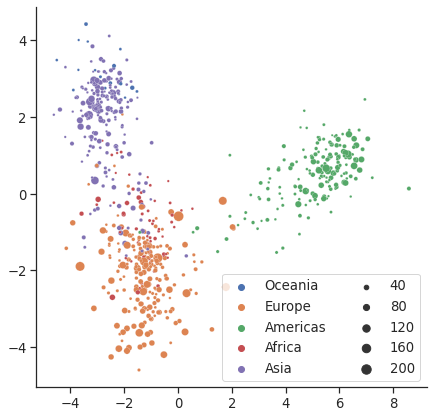

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt 

# Dimensionality reduction 
pca = PCA(n_components=2).fit(emb)
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#xy = pca.transform(emb)
clf = LinearDiscriminantAnalysis(n_components=2)
xy = clf.fit_transform(emb, labels)
#logging.getLogger("urllib3").setLevel(level=logging.DEBUG)
degree = np.array(adj.sum(axis = 1)).ravel()

# Plot 
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,7))

sns.scatterplot(
    x=xy[:, 0],
    y=xy[:, 1],
    hue=labels,
    size=degree,
    sizes=(5, 100),
    ax=ax,
)
ax.legend(ncol=2)
sns.despine()

To test the validity of the equivalence, let us compare the actual flow $T_{ij}$ and the predicted flow $\hat T_{ij}$ by the word2vec model. Since calculating the gravitational constant $G$ is computationally expensive, we drop $G$ and calculate the predicted flow. In other words, we will calculate un-normalized flows that are proportional to the flows predicted by word2vec. We will test if this un-normalized predicted flow is in linear relation to the actual flow: 

In [ ]:
import pandas as pd
from scipy import stats

# Counting the actual flows
pair_ids, freq = np.unique(
    np.concatenate([np.array(seq[:-1]) + np.array(seq[1:]) * n_nodes for seq in seqs]),
    return_counts=True,
)
_to, _from = divmod(pair_ids, n_nodes)
flow_table = pd.DataFrame({"from": _from, "to": _to, "flow": freq}).astype(
    {"from": int, "to": int, "flow": float}
)
flow_table["log_flow"] = np.log(flow_table["flow"])

# Calculate the predicted flows
def predicted_log_flow_euclidean(_from, _to, mass, emb):
    """Calculate the logarithmic flow by the word2vec using Eq. (3)""" 
    return (
        np.log(mass[_from])
        + np.log(mass[_to])
        - np.array(np.linalg.norm(emb[_from, :] - emb[_to, :], axis=1).reshape(-1))
    )

mass = np.bincount(
    flow_table["from"], weights=flow_table["flow"], minlength=n_nodes
) + np.bincount(flow_table["to"], weights=flow_table["flow"], minlength=n_nodes)
flow_table["predicted_log_flow"] = predicted_log_flow_euclidean(
    flow_table["from"], flow_table["to"], mass, emb
)

In [ ]:

# Plot the actual and predicted flows
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Bin the actual flows for visual clarity
bin_width = 0.1
flow_table["log_flow_binned"] = flow_table["log_flow"] // bin_width * bin_width

fig, ax = plt.subplots(figsize=(5, 5))

sns.lineplot(
    data=flow_table,
    x="log_flow_binned",
    y="predicted_log_flow",
    color=sns.color_palette().as_hex()[1],
    ax=ax,
    marker="o",
)
rho = stats.pearsonr(flow_table["log_flow"], flow_table["predicted_log_flow"])[0]

ax.annotate(
    f"Pearson R={rho:.2f}",
    (0.05, 1 - 0.05),
    xycoords="axes fraction",
    ha="left",
    va="top",
    fontsize=20,
)
ax.set_ylabel("(Unnormalized) Predicted flow (log)")
ax.set_xlabel("Actual flow (log)")
sns.despine()


The actual and the predicted flows are overall in linear relationship, supporting the equivalence. 


# From flow to gravity potential 

We can draw analogy from mechanical physics to define *the gravity potential* over embedding space. What is interesting about the gravity potential interesting? I'll show you in this section, but here are the summary: 
1. We can calculate a flow at any point in space by taking the derivative of the gravity potential.
2. A local minimum is an area that attracts the flow around it. We can systematically identify local minima, and cluster the points in non-parametric and unsupervised fashion based on which local minimum the points are attracted to.  
3. Local minima (i.e., basins) are separated by local maximals (i.e., hills) of different hight. The hight of the hills corresponds to unlikeliness of the flow between the local minima.  

### What is the gravitational potential?
![gravity potential](https://www.schoolphysics.co.uk/age16-19/Mechanics/Gravitation/text/Gravitational_potential/images/7.png)

Let's start from the concept of the gravity potential in mechanical physics. Suppose two objects $i$ and $j$ at locations $u_i$ and $u_j$ with mass $P(i)$ and $P(j)$. Let $d(u_i, u_j)$ be the distance between $i$ and $j$. The two objects pull each other with a gravitational force
$$
F(d(i,j)) = -G\frac{P(u_i)P(u_j)}{d(u_i, u_j)^2}.
$$
An observer at location $u_i$ would see that the other object at $u_j$ is falling down. This can be interpreted that object $j$ has an *energy potential* due to the gravitational forces $F$. If $j$ moves closer to $i$, $j$ gains some energy, whereas if $j$ moves away from $i$, $j$ loses some energy. The gravitational potential at $u_j$ is the amount of energy per mass that $j$ gains by moving to the location $u_j$ from a location infinitely far away, i.e., 
$$
\phi(u_j;u_i) = \frac{1}{P(j)}\int_{\infty} ^{d(u_i, u_j)} F(r) {\rm d}r,
$$ 
which yields the gravity potential
$$
\phi(u_j;u_i) = -G\frac{P(i)}{d(u_i, u_j)}.
$$
The gravity potential is *additive*. That is, in a space with $N$ point masses $P(1),\ldots,P(N)$ at locations $u_1, \ldots, u_N$, the gravity potential at location $x$ is given by
$$
\Phi(x) = \sum_{i=1}^N \phi(x;u_i) = -G\sum_{i=1}^N \frac{P(i)}{d(x, u)}.
$$
Why do we define the potential in this way? You should ask your Physics teacher. But one important property is that it's derivative gives you all information about the gravitational forces, including the direction and intensity.

### Gravitational potential over embedding

We can derive the gravity potential for embedding by noting that the gravitational force is mathematically analogous to flow predicted by the word2vec. Unfortunately, the integral does not have a convenient closed-form solution. For some distance metrics, we can obtain a closed form solution. For example, with the Euclidean distance, the potential at location $x$ generated by a point mass at location $u$ is given by 
$$
\Phi(x) = \sum_{i=1}^N \phi(x;u_i) = -G\sum_{i=1}^N P(i)\exp(-d(x, u)).
$$
The same for the angular distance metric. 


### Example

Let us calculate the gravity potential for the embedding of the worldwide airport network. To start, let us calculate the gravitational potential at each airport in space. Which airport has the lowest and the highest potential? 

In [ ]:
from scipy import spatial

# Calculate the gravitational potential
def calc_grav_potential(x, emb, mass):
    return -1 * np.sum(
        mass * np.exp(-spatial.distance.cdist(x, emb, "euclidean")), axis=1
    )


# Compute the mass (i.e., the frequency of each airport in the shortest paths.)
# Note that the mass is proportional to the betweenness centrality of each airport.
mass = np.bincount(np.concatenate(seqs), minlength=n_nodes).astype(float)
mass /= np.sum(mass)

Phi = calc_grav_potential(emb, emb, mass)

# Print the top 10 airports with the smallest potential
df = node_table.copy()
df["grav_potential"] = Phi
df["mass"] = mass
df["deg"] = degree
df.sort_values(by="grav_potential")[
    ["Name", "City", "Country", "deg", "grav_potential", "mass"]
]


The gravitational potential is correlated but not identical to the degree and mass (i.e., betweenness centrality)

In [ ]:
df[["grav_potential", "deg", "mass"]].corr()

### Visualizing the gravity potential

The gravitational potential is a field in a high dimensional space. Let us visualize the potential by reducing its dimensions as follows. 
1. We sample points from a distribution that is proportional to the absolute value of the gravity potential (which is easy to do. See the code).
2. Then, we project the sampled points onto a 2D plane. 
3. We apply the kernel density estimation on the 2D plane to visualize the potential landscape. 

The distribution on the 2D plane corresponds to the marginal of the gravitational potential, and we are free to use any linear projection method. We will use the PCA for this demonstration. It is also possible to use non-linear dimensionality reduction techniques such as UMAP but, with a caution that the density may not correspond to the marginal distribution. 

In [ ]:
from sklearn.decomposition import PCA

# Sample from the gravitational potential
def sample_from_grav_potential(emb, mass, num_samples):
    """Sample from a distribution proportional to the magnitude of the gravitationa potential.
    We take advantage of the fact that the gravitational potential is a sum of exponential functions, i.e.,
        Potential \propto \sum_{j} P(j) \exp(-x_j)
    where P(j) is the mass of the j-th node, x_j is the distance to the point mass j. We first sample
    a point mass $j$ with probability proportional to P(j), and then draw a distance $d$ from an exponential distribution exp(-d).
    With the sampled point mass $j$ and distance $d$, we compose a random point x_j + d * b, where $b$ is a random vector of unit length 1.
    """
    mass = mass.astype(np.float32)
    p = mass / np.sum(mass)
    dim = emb.shape[1]

    # Draw random directions
    d = np.random.randn(num_samples, dim)
    d = np.einsum("ij,i->ij", d, 1 / np.linalg.norm(d, axis=1))

    # Draw distance from the masses
    r = np.random.exponential(size=num_samples)

    # Select the masses
    centers = np.random.choice(emb.shape[0], size=num_samples, p=p)

    # Putting them together
    return emb[centers, :] + np.einsum("i,ij->ij", r, d)


emb_sampled = sample_from_grav_potential(emb, mass, num_samples=2000)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grav_potential(emb, labels, emb_rand, pca, ax):
    """Plotter for the gravitational potential. 
    - Plot the nodes with colors corresponding to 'labels'.
    - Plot the gravitational potential using the points `emb_rand` sampled from the potential.
    - `pca` is the scikit-learn PCA class for the dimensionality reduction.
    - The node size is proportional to the mass. 
    """
    xy = pca.transform(emb) 
    xy_rand = pca.transform(emb_rand) 

    sns.kdeplot(
        x = xy_rand[:, 0], y = xy_rand[:, 1],
        cmap="mako",
        fill=True,
        thresh=0,
        levels=200,
        ax=ax,
    )
    
    sns.scatterplot(
        x=xy[:, 0],
        y=xy[:, 1],
        hue=labels,
        size=mass, # betweenness centrality
        sizes=(10, 200),
        zorder = 10,
        ax=ax,
    )
    
    
    # Set the canvas size 
    xmin, xmax = np.min(xy[:, 0]), np.max(xy[:, 0]), 
    ymin, ymax = np.min(xy[:, 1]), np.max(xy[:, 1])
    dx, dy = xmax - xmin, ymax - ymin 
    xmin, xmax =xmin - dx * 0.1, xmax + dx * 0.1
    ymin, ymax =ymin - dy * 0.1, ymax + dy * 0.1
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.legend(ncol=2)
    ax.axis("off")
    return ax

# Train the dimensionality reducer 
pca = PCA(n_components=2).fit(emb_sampled)

# Plot
sns.set_style('white')
sns.set(font_scale=0.9)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,7))

ax = plot_grav_potential(emb, labels, emb_sampled, pca, ax)

sns.despine()

The landscape provides some insights into the flows. 
- ***Inter-regional flows***
There are several "basins" in the gravitational potential. Each basin corresponds to a regional cluster of airports, and is separated from other basins by the "hills" of the gravity potential.
The Asian and American clusters are separated by a higher energy hill than that betweeen Asian and European clusters, suggesting that the Asia-America flows are unlikely than Asia-Europe flows. 
- ***Within-regional flows***
Flows are likely to occur between close airports, and intense if the flows go along a steep slope of the landscape. Since airports within the same basin are close to each other and have a similar potential, each basin has many but small flows within it. 

In case you might wonder if this is really the case, let us overlay the flows on the 2D plane. Each flow is represented as a grey line, with the width and opacity indicating the amount of the flow between the airports.  

In [ ]:
from collections import Counter

# Sample some paths and count the flows
n_samples = 5000
sampled_flow = Counter(
    [
        (seqs[i][t - 1], seqs[i][t])
        for i in np.random.choice(len(seqs), n_samples)
        for t in range(1, len(seqs[i]))
    ]
)


# Plot
sns.set_style("white")
sns.set(font_scale=0.9)
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(7, 7))
ax = plot_grav_potential(emb, labels, emb_sampled, pca, ax)

# Plot the flow.The line width and the opacity of lines are set by the number of flows
xy = pca.transform(emb)
vall = max(sampled_flow.values())
for k, v in sampled_flow.items():
    flow = v / vall
    ax.plot(xy[k, 0], xy[k, 1], color="white", alpha=np.minimum(flow, 0.2), lw=5 * flow)

sns.despine()


- There are more flows between Asian and European clusters than between Asian and American clusters.
- The within-regional flow are relatively small compared to inter-regional flows.

The gravitational potential captures flows not only at global level but also within each region. We visualize the gravitational potential region-wise by calculating the potential based on the airports in the respective region. 

In [ ]:
# Plot 
def plot_regional_landscape(region_name, ax):
    s = labels == region_name 
    subemb = emb[s, :]
    submass = mass[s]
    sublabels = node_table.iloc[s]["sub-region"].values
    
    sampled = sample_from_grav_potential(subemb, submass, num_samples = 5000)
    
    # Dimensionality reduction
    pca = PCA(n_components=2).fit(subemb)
    xys = pca.transform(subemb) 
    xy_rand = pca.transform(sampled) 
    
    xmin, xmax = np.min(xys[:, 0]), np.max(xys[:, 0]), 
    ymin, ymax = np.min(xys[:, 1]), np.max(xys[:, 1])
    dx, dy = xmax - xmin, ymax - ymin 
    xmin, xmax =xmin - dx * 0.1, xmax + dx * 0.1
    ymin, ymax =ymin - dy * 0.1, ymax + dy * 0.1
    sns.kdeplot(
        x = xy_rand[:, 0], y = xy_rand[:, 1],
        cmap="mako",
        fill=True,
        thresh=0,
        levels=100,
        ax=ax,
    )
    sns.scatterplot(
        x=xys[:, 0],
        y=xys[:, 1],
        hue=sublabels,
        size=mass[s], # betweenness centrality
        sizes=(10, 200),
        ax=ax,
    )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    n_labels = len(set(sublabels))
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:n_labels], l[:n_labels])
    ax.set_title(region_name)
    ax.axis("off")

sns.set_style('white')
sns.set(font_scale=0.9)
sns.set_style('ticks')

fig, axes = plt.subplots(ncols = 3, nrows =2,  figsize=(15,10))


plot_regional_landscape("Americas", axes[0, 0])
plot_regional_landscape("Africa", axes[0, 1])
plot_regional_landscape("Asia", axes[0, 2])
plot_regional_landscape("Europe", axes[1, 0])
plot_regional_landscape("Oceania", axes[1,1])
axes[1, 2].axis("off")
sns.despine()

Within each region, the basins correspond to sub-regional clusters with a different level of potential. For example, tn Americas, there are roughly two basins, one for North America and the other for Latin and the Caribbean. North America has a lower gravitational potential so that flows from Latin America and Caribbean tend to go into the North America. 

### Finding local minima

Flows go along the gravity potential landscape from high to low potential, so that a flow from an airport ends up with a local minimum around the airport. A local minimum corresponds to an area that attracts flows from its surroundings and thus can be seen as a regional center. How many local minima are there, and where are they?

We find them by simulating and following the flows. Specifically, the flow at location $x$ is the gradient of the gravitational landscape. 
$$
\frac{\partial }{\partial x} \Phi(x) = G\sum_{i=1}^N P(u_i)\exp(-d(x, u_i)) \frac{u_i - x}{||u_i - x||}.
$$
To approach a local minimum, we walk along the gradient with a small step $\epsilon$, and repeat this process many times. This is exactly the same process as running a gradient descent algorithm on the gravity potential. 

We run a gradient descent algorithm from 500 airports sampled randomly, and find the local minima around them. 

In [ ]:
import faiss
import torch
from tqdm import tqdm


def gradient_descent(
    x0, emb, mass, max_iter=1000, k=500, mode="descent", return_path=False
):
    """Gradient descent algorithm on the gravitational potential.
    To reduce the computation time, the gradient at a location is calculated
    based on the k nearest point masses for the location.
    """

    # Get the dimension
    dim = emb.shape[1]

    # Set up the faiss database
    index = faiss.IndexFlatL2(dim)
    index.add(emb.astype(np.float32))

    # Gradient calculation
    def calc_gradient(x, mass, emb):
        distances, indices = index.search(x.astype(np.float32), k)
        grad = np.zeros_like(x)
        for i in range(distances.shape[0]):
            dist = distances[i, :]
            neis = indices[i, :]
            dx = emb[neis, :] - x[i, :]
            dx = np.einsum(
                "ij,i->ij", dx, 1 / np.maximum(np.linalg.norm(dx, axis=1), 1e-10)
            )
            grad[i, :] = np.einsum("i,ij->j", mass[neis] * np.exp(-dist), dx)
        if mode == "descent":
            return -grad
        elif mode == "ascent":
            return grad

    # Gradient descent
    xt = torch.nn.Parameter(torch.from_numpy(x0.copy()), requires_grad=True)
    optim = torch.optim.SGD([xt], lr=0.01)
    Xt = [x0]
    for it in tqdm(range(max_iter)):
        dx = calc_gradient(xt.detach().numpy(), mass, emb)
        xt.grad = torch.from_numpy(dx)
        optim.step()
        Xt.append(xt.detach().numpy())

    if return_path:
        return Xt
    else:
        return xt.detach().numpy()


# Run a gradient descent from randomly-chosen airports in space
sampled_nodes = np.random.choice(emb.shape[0], size = 500, replace = False)
local_mins = gradient_descent(
    emb[sampled_nodes, :], emb, mass, k=200, max_iter=5000, mode="descent", return_path=True
)


Let us visualize the local minima for each airport. A star indicates the local minima, identified by the flows from airports connected by the white lines.  

In [ ]:
# Dimensionally reduce the local minima
xy_lm = pca.transform(local_mins[-1])

# Plot 
sns.set_style('white')
sns.set(font_scale=0.9)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(7,7))
plot_grav_potential(emb, labels, emb_sampled, pca, ax)
sns.scatterplot(
    x=xy_lm[:, 0],
    y=xy_lm[:, 1],
    color = "yellow",
    edgecolor = "black",
    s=100,
    zorder = 11,
    marker = "*",
    ax=ax,
)

xy = pca.transform(emb)
for i, k in enumerate(sampled_nodes):
    flow = v / vall
    ax.plot([xy[k, 0], xy_lm[i, 0]], [xy[k, 1], xy_lm[i, 1]], color="white")

sns.despine()

There are only a handful of local minima for randomly-sampled 500 airports. Each local minima is located near the center of the basin that the airport is in. The European cluster roughly has two local minima. This result demonstrates the utility of local minima for clustering, i.e., we can find clusters of airports based on which local minima they are attracted to. We can also draw a border line between the clusters based on the boundaries of attractions. 

# Summary and the next steps 

- The mathematical equivalence between gravity model and word2vec holds for other similarity metrics such as the Euclidean and angular distance metrics.  
- Drawing analogies from mechanical physics, we can consider a gravitational potential over embedding space. The gravitational potential is a different way to represent flows in space, where the direction and the intensity of a flow at a location is the gradient of the landscape at that location. 
- Gravity potential provides some insights about flows that cannot be revealed by the distance between points. For example, even if two points are close, flows are unlikely to occur between them if they are separated by a large hill in the gravity potential.
- Local minima in the gravity potential may be used to find clusters based on what nodes they attract. 